<a href="https://colab.research.google.com/github/shivavarma2001/HOMEWORK-NLP4/blob/main/homework4NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vocabulary size: 13
Epoch 1/10 | Train Loss: 0.481 | Val Loss: 0.046
Epoch 2/10 | Train Loss: 0.034 | Val Loss: 0.028
Epoch 3/10 | Train Loss: 0.028 | Val Loss: 0.029
Epoch 4/10 | Train Loss: 0.026 | Val Loss: 0.027
Epoch 5/10 | Train Loss: 0.025 | Val Loss: 0.023
Epoch 6/10 | Train Loss: 0.025 | Val Loss: 0.026
Epoch 7/10 | Train Loss: 0.025 | Val Loss: 0.023
Epoch 8/10 | Train Loss: 0.024 | Val Loss: 0.025
Epoch 9/10 | Train Loss: 0.024 | Val Loss: 0.024
Epoch 10/10 | Train Loss: 0.024 | Val Loss: 0.025


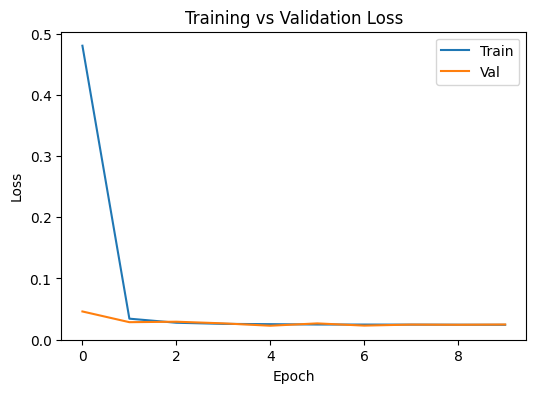


--- Temperature 0.7 ---

help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful 

------------------------------------------------------------

--- Temperature 1.0 ---

help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help hel

------------------------------------------------------------

--- Temperature 1.2 ---

help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helmet hello hell helpful help hello world hello help helm

'\nReflection:\n- Longer sequence lengths capture more dependencies but slow training.\n- Larger hidden sizes increase coherence but may overfit small data.\n- Lower temperature (τ=0.7) = more predictable, repetitive text.\n- Higher temperature (τ=1.2) = more random, creative but error-prone output.\n- Teacher forcing helps stabilize learning early in training.\n'

In [18]:

#  Step 2: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

#  Step 3: Prepare Dataset
# Option 1: Use toy corpus
text = "hello help helmet hello hell helpful help hello world " * 50

# Option 2: Use your own file (uncomment below)
# from google.colab import files
# uploaded = files.upload()
# filename = list(uploaded.keys())[0]
# with open(filename, "r") as f:
#     text = f.read().lower()

# Build vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocabulary size: {vocab_size}")

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

# Split into train and validation
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Step 4: Define the Model
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=64, hidden_size=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x, h=None):
        x = self.embed(x)
        out, h = self.rnn(x, h)
        logits = self.fc(out)
        return logits, h

model = CharRNN(vocab_size, embed_size=64, hidden_size=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Step 5: Training Loop
seq_len = 80
batch_size = 64
epochs = 10

def get_batch(split):
    data_ = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_) - seq_len - 1, (batch_size,))
    x = torch.stack([data_[i:i+seq_len] for i in ix])
    y = torch.stack([data_[i+1:i+seq_len+1] for i in ix])
    return x.to(device), y.to(device)

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step in range(200):  # 200 mini-batches per epoch
        xb, yb = get_batch('train')
        optimizer.zero_grad()
        logits, _ = model(xb)
        loss = criterion(logits.view(-1, vocab_size), yb.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        xb, yb = get_batch('val')
        logits, _ = model(xb)
        val_loss = criterion(logits.view(-1, vocab_size), yb.view(-1)).item()

    train_losses.append(total_loss / 200)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/200:.3f} | Val Loss: {val_loss:.3f}")

#  Step 6: Plot Loss Curves
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Step 7: Sampling Function
def sample(model, start="h", length=300, temperature=1.0):
    model.eval()
    input = torch.tensor([[stoi[start]]]).to(device)
    hidden = None
    out_text = start
    for _ in range(length):
        output, hidden = model(input, hidden)
        logits = output[0, -1] / temperature
        probs = F.softmax(logits, dim=0)
        next_id = torch.multinomial(probs, 1).item()
        out_text += itos[next_id]
        input = torch.tensor([[next_id]]).to(device)
    return out_text

# Step 8: Generate Samples
for t in [0.7, 1.0, 1.2]:
    print(f"\n--- Temperature {t} ---\n")
    print(sample(model, start='h', temperature=t, length=300))
    print("\n" + "-"*60)

#  Step 9: Reflection
"""
Reflection:
- Longer sequence lengths capture more dependencies but slow training.
- Larger hidden sizes increase coherence but may overfit small data.
- Lower temperature (τ=0.7) = more predictable, repetitive text.
- Higher temperature (τ=1.2) = more random, creative but error-prone output.
- Teacher forcing helps stabilize learning early in training.
"""


Vocab size: 37
✅ Contextual embeddings shape: torch.Size([10, 5, 64])
✅ Attention weight tensor shape: torch.Size([10, 4, 5, 5])


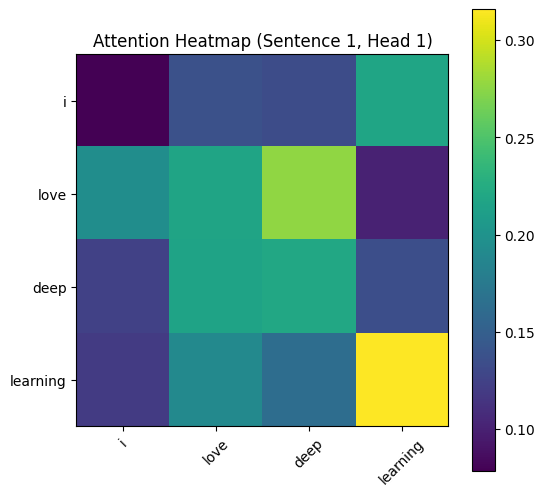


Input tokens: ['i', 'love', 'deep', 'learning']

Contextual embedding (first sentence):
 tensor([[-0.6350, -0.9805, -0.2055,  0.8302, -0.4652,  1.0423,  1.6598, -1.1897,
         -0.3136, -1.0622, -0.9857,  0.4207,  0.9083,  0.0878, -0.3332,  1.7990,
         -0.1214,  1.8198, -0.5741,  0.2245, -1.7340,  0.0349,  0.3836,  0.6915,
          0.8013,  0.2804, -1.8557, -0.5753,  0.7654,  1.0488, -1.8686,  0.0945,
          0.0319, -1.2827,  0.1475, -0.2300,  0.7613,  0.7909, -2.3202,  1.2269,
         -0.0294, -0.0570, -0.8730,  1.9760,  0.8218, -1.3495, -2.1605,  0.0977,
          0.1240,  0.9597, -0.9898, -0.2478,  0.5717,  0.7559, -0.8458,  1.7772,
         -0.2002,  0.1103,  0.0223,  0.5859, -0.9408,  1.3080, -1.0769,  0.5415],
        [ 1.9843, -0.3843,  1.1716,  0.0306,  0.5018,  1.3817,  1.0173,  0.4397,
          0.8586,  0.3577,  0.5224,  0.8934,  1.2636, -0.0832,  0.1595, -0.8046,
         -0.4197,  0.8514, -2.1659,  0.9427, -0.6535,  1.2618, -1.3323, -0.1638,
          0.0615, 

In [21]:

sentences = [
    "i love deep learning",
    "transformers are powerful",
    "attention is all you need",
    "nlp is fun",
    "pytorch makes it easy",
    "the model learns patterns",
    "language models are cool",
    "machine learning is amazing",
    "rnn and lstm remember context",
    "we build a mini transformer"
]

tokens = [s.split() for s in sentences]
vocab = sorted(set(sum(tokens, [])))
tok2id = {w: i for i, w in enumerate(vocab)}
id2tok = {i: w for w, i in tok2id.items()}

max_len = max(len(t) for t in tokens)
ids = [[tok2id[w] for w in t] + [0]*(max_len - len(t)) for t in tokens]
inputs = torch.tensor(ids)
vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")

# --------------------------------------------
# 2️⃣ Positional Encoding
# --------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1)]

# --------------------------------------------
# 3️⃣ Transformer Encoder Layer
# --------------------------------------------
class MiniEncoderLayer(nn.Module):
    def __init__(self, d_model=64, n_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Linear(128, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
    def forward(self, x):
        attn_out, attn_weights = self.attn(x, x, x, need_weights=True, average_attn_weights=False)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x, attn_weights  # shape: (batch, heads, seq, seq)

# --------------------------------------------
# 4️⃣ Build model
# --------------------------------------------
d_model = 64
embed = nn.Embedding(vocab_size, d_model)
pos_enc = PositionalEncoding(d_model)
encoder = MiniEncoderLayer(d_model=d_model, n_heads=4)

# Forward pass
x = embed(inputs)
x = pos_enc(x)
contextual, attn_weights = encoder(x)

print("✅ Contextual embeddings shape:", contextual.shape)
print("✅ Attention weight tensor shape:", attn_weights.shape)  # (batch, heads, seq, seq)

# --------------------------------------------
# 5️⃣ Visualize attention (Fixed)
# --------------------------------------------
def plot_attention(sentence_idx=0, head_idx=0):
    # attn_weights shape: (batch, heads, seq, seq)
    attn = attn_weights[sentence_idx, head_idx].detach().cpu().numpy()
    token_list = tokens[sentence_idx]
    seq_len = len(token_list)

    plt.figure(figsize=(6,6))
    plt.imshow(attn[:seq_len, :seq_len], cmap='viridis')
    plt.xticks(range(seq_len), token_list, rotation=45)
    plt.yticks(range(seq_len), token_list)
    plt.title(f"Attention Heatmap (Sentence {sentence_idx+1}, Head {head_idx+1})")
    plt.colorbar()
    plt.show()

plot_attention(sentence_idx=0, head_idx=0)

# --------------------------------------------
# 6️⃣ Outputs
# --------------------------------------------
print("\nInput tokens:", tokens[0])
print("\nContextual embedding (first sentence):\n", contextual[0])


In [27]:

import torch
import torch.nn.functional as F
import math

# --------------------------------------------
# 1️⃣ Define the Scaled Dot-Product Attention
# --------------------------------------------
def scaled_dot_product_attention(Q, K, V):
    """
    Computes attention(Q,K,V) = softmax((QK^T)/√d_k) * V
    Q, K, V: tensors of shape (batch, seq_len, d_k)
    Returns: (output, attention_weights)
    """
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

# --------------------------------------------
# 2️⃣ Generate Random Q, K, V Inputs
# --------------------------------------------
torch.manual_seed(0)
batch_size = 1
seq_len = 4
d_k = 8

Q = torch.randn(batch_size, seq_len, d_k)
K = torch.randn(batch_size, seq_len, d_k)
V = torch.randn(batch_size, seq_len, d_k)

print("Q shape:", Q.shape)
print("K shape:", K.shape)
print("V shape:", V.shape)

# --------------------------------------------
# 3️⃣ Check Softmax Stability (Before / After Scaling)
# --------------------------------------------
raw_scores = torch.matmul(Q, K.transpose(-2, -1))
print("\nRaw attention scores (no scaling):\n", raw_scores[0])

scaled_scores = raw_scores / math.sqrt(d_k)
print("\nScaled attention scores (divided by √d_k):\n", scaled_scores[0])

# --------------------------------------------
# 4️⃣ Compute Attention
# --------------------------------------------
output, weights = scaled_dot_product_attention(Q, K, V)

print("\n✅ Attention Weights (softmax over scaled scores):\n", weights[0])
print("\n✅ Output Vectors:\n", output[0])

# --------------------------------------------
# 5️⃣ Verify Stability — Observe numeric range
# --------------------------------------------
print("\nScore Range Comparison:")
print("Unscaled scores range:  ", raw_scores.min().item(), "→", raw_scores.max().item())
print("Scaled scores range:    ", scaled_scores.min().item(), "→", scaled_scores.max().item())

"""
🧠 Notes for Report
- Formula: Attention(Q,K,V) = softmax((QKᵀ)/√dₖ) V
- Dividing by √dₖ prevents extremely large dot-products,
  which could cause the softmax to saturate and give unstable gradients.
- The attention weight matrix shows how each query attends to keys,
  and the weighted sum of V produces context-aware output vectors.
"""

Q shape: torch.Size([1, 4, 8])
K shape: torch.Size([1, 4, 8])
V shape: torch.Size([1, 4, 8])

Raw attention scores (no scaling):
 tensor([[-0.0146,  5.1091, -0.3921, -3.7779],
        [ 0.4648,  0.5446, -0.7034,  0.9571],
        [ 1.3816, -7.0338, -0.2771,  2.2690],
        [ 0.6756,  3.8463, -1.2603, -2.3062]])

Scaled attention scores (divided by √d_k):
 tensor([[-0.0052,  1.8063, -0.1386, -1.3357],
        [ 0.1643,  0.1926, -0.2487,  0.3384],
        [ 0.4885, -2.4868, -0.0980,  0.8022],
        [ 0.2389,  1.3599, -0.4456, -0.8154]])

✅ Attention Weights (softmax over scaled scores):
 tensor([[0.1211, 0.7410, 0.1060, 0.0320],
        [0.2577, 0.2651, 0.1705, 0.3067],
        [0.3360, 0.0171, 0.1869, 0.4599],
        [0.2032, 0.6235, 0.1025, 0.0708]])

✅ Output Vectors:
 tensor([[-1.2940, -0.1495, -0.3701, -0.2156, -0.9138,  1.0640, -0.0503,  0.6983],
        [-0.6700,  0.9147, -0.5610,  0.1849, -0.8407,  0.5956,  0.0283,  0.5789],
        [-0.3498,  1.4870, -0.6570,  0.4022, -0.83

'\n🧠 Notes for Report\n- Formula: Attention(Q,K,V) = softmax((QKᵀ)/√dₖ) V\n- Dividing by √dₖ prevents extremely large dot-products,\n  which could cause the softmax to saturate and give unstable gradients.\n- The attention weight matrix shows how each query attends to keys,\n  and the weighted sum of V produces context-aware output vectors.\n'